# Goal

Jacobo de la Cuesta-Zuluaga, May 2019.

The aim of this notebook is to compare the profiles obtained with the different databases on the BGI250 data

# Init

In [1]:
library(tidyverse)
library(stringr)
library(forcats)
library(cowplot)
library(data.table)
library(glue)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Warning message:
“package ‘ggplot2’ was built under R version 3.4.3”Warning message:
“package ‘tibble’ was built under R version 3.4.3”Warning message:
“package ‘tidyr’ was built under R version 3.4.3”Warning message:
“package ‘purrr’ was built under R version 3.4.3”Warning message:
“package ‘dplyr’ was built under R version 3.4.3”Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Warning message:
“package ‘stringr’ was built under R version 3.4.3”
Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Warning message:
“package ‘data.table’ was built under R version 3.4.3”
Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked fr

# Var

In [2]:
work_dir = "/ebio/abt3_projects/Struo/struo_benchmark/data/profiles_BGI250"

## Dataframe with Kraken classification reads

In [3]:
# Kraken proportion of reads mapped
database = c("GTDB", "progenomes", "defaults")
kraken_logs = map(database, 
                  function(x) file.path(work_dir, x, "logs/kraken") %>% 
                  list.files(., full.names = T)) %>% unlist

In [4]:
read_klog = function(path){
    
    # Sample community name
    community_name = path %>%
        basename %>%
        str_replace(., ".log", "")

    # Database
    db = path %>%
        str_split("/", simplify = T) %>%
        nth(8)
    
    # Read file line by line
    # Keep lines with classified and unclassified reads
    # create table with data for each sample
    readLines(path) %>%
        data.frame(txt = .) %>%
        tail(., n=2) %>%
        separate(txt, into = c("seqs", "category"), sep = "sequences") %>%
        mutate(seqs = as.numeric(seqs), 
               category = c("classified", "unclassified"), 
               community = rep(community_name, 2), 
               database = rep(db, 2))
}



In [5]:
kraken_classified_complete = map_df(kraken_logs, function(x) read_klog(x)) %>% 
                           arrange(community)
                           
kraken_classified_complete %>% head

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.3”

seqs,category,community,database
27412288,classified,1002314,GTDB
8438016,unclassified,1002314,GTDB
20951737,classified,1002314,progenomes
14898567,unclassified,1002314,progenomes
15580619,classified,1002314,defaults
20269685,unclassified,1002314,defaults


In [6]:
kraken_classified = kraken_classified_complete %>% 
    group_by(database, community) %>%
    mutate(sum = sum(seqs)) %>% 
    ungroup %>%
    mutate(proportion = round((seqs/sum)* 100, 2)) %>%
    select(-sum) %>%
    filter(category == "classified") %>%
    arrange(community, -proportion) %>%
    mutate(database = fct_recode(database, RefSeq = "defaults", proGenomes = "progenomes")) %>%
    mutate(database = fct_relevel(database, c("RefSeq", "proGenomes", "GTDB")))
kraken_classified %>% head

seqs,category,community,database,proportion
27412288,classified,1002314,GTDB,76.46
20951737,classified,1002314,proGenomes,58.44
15580619,classified,1002314,RefSeq,43.46
34683189,classified,1002317,GTDB,71.20
28770535,classified,1002317,proGenomes,59.06
17366796,classified,1002317,RefSeq,35.65


## Read Bracken logs

In [7]:
# Kraken proportion of reads mapped
database = c("GTDB", "progenomes", "defaults")
bracken_logs = map(database, 
                  function(x) file.path(work_dir, x, "logs/bracken") %>% 
                  list.files(., full.names = T)) %>% unlist

In [8]:
read_blog = function(path){
    
    # Synth community name
    community_name = path %>%
        basename %>%
        str_replace(., ".log", "")

    # Database
    db = path %>%
        str_split("/", simplify = T) %>%
        nth(8)
    
    
    # Read file line by line
    # Keep lines with total and used reads at the species level
    # create table with data for each sample
    readLines(path) %>%
        data.frame(txt = .) %>%
        filter(str_detect(txt," Total reads in sample") | str_detect(txt,"Total reads kept")) %>%
        separate(txt, into = c("txt", "seqs"), sep = ":") %>%
        select("seqs") %>% 
        mutate(seqs = as.numeric(seqs), 
               category = c("Total", "Used"), 
               community = rep(community_name, 2), 
               database = rep(db, 2))
}

In [9]:
bracken_used_complete = map_df(bracken_logs, function(x) read_blog(x)) %>% 
    arrange(community) %>%
    mutate(database = fct_recode(database, RefSeq = "defaults", proGenomes = "progenomes")) %>%
    mutate(database = fct_relevel(database, c("RefSeq", "proGenomes", "GTDB")))
                           
bracken_used_complete %>% head

seqs,category,community,database
35850304,Total,1002314,GTDB
21843126,Used,1002314,GTDB
35850304,Total,1002314,proGenomes
18541042,Used,1002314,proGenomes
35850304,Total,1002314,RefSeq
13956784,Used,1002314,RefSeq


## Bracken species table

In [10]:
bracken_tables = function(file_path){
    tax_levels = c("Domain", "Phylum", "Class",
                   "Orden", "Family", "Genus", "Species")
    
    id_ranks = c("id_cellular", "id_Domain", "id_Phylum", "id_Class",
               "id_Order", "id_Family", "id_Genus",
               "id_Species")  
    
    # Read table, select columns and separate taxonomy
    tbl_raw = read_delim(file_path, delim = "\t") %>%
        select(-c(name, taxonomy_lvl)) %>%
        separate(taxonomy, into = tax_levels, sep = ";") %>%
        separate(taxIDs, into = id_ranks, sep = ";") %>%
        select(-id_cellular)
        
    
    # Create fractiion and count tables
    # Raw counts
    tbl_count = tbl_raw %>% 
        select(-ends_with("_frac"))
    
    # Relative abudnances
    tbl_fraction = tbl_raw %>% 
        select(-ends_with("_num")) 
    
    percentages = tbl_fraction %>% 
        select(ends_with("_frac")) %>%
        (function(x) (x * 100))
         
    tbl_fraction = tbl_fraction %>% 
        select(-ends_with("_frac")) %>%
        bind_cols(percentages)
        
    
    list(relabund = tbl_fraction, count = tbl_count)
}

In [11]:
# Paths
defaults_bracken_path = file.path(work_dir, "defaults/kraken/all-combined-bracken.tsv")
progenomes_bracken_path = file.path(work_dir, "progenomes/kraken/all-combined-bracken.tsv")
gtdb_bracken_path = file.path(work_dir, "GTDB/kraken/all-combined-bracken.tsv")

In [12]:
# Defaults
bracken_defaults = bracken_tables(defaults_bracken_path)
defaults_relabund = bracken_defaults$relabund

# progenomes
bracken_progenomes = bracken_tables(progenomes_bracken_path)
progenomes_relabund = bracken_progenomes$relabund

# gtdb
bracken_gtdb = bracken_tables(gtdb_bracken_path)
gtdb_relabund = bracken_gtdb$relabund

Parsed with column specification:
cols(
  .default = col_integer(),
  name = col_character(),
  taxonomy_lvl = col_character(),
  taxonomy = col_character(),
  taxIDs = col_character(),
  `1002324_frac` = col_double(),
  `1002325_frac` = col_double(),
  `1002317_frac` = col_double(),
  `1002331_frac` = col_double(),
  `1002336_frac` = col_double(),
  `1002337_frac` = col_double(),
  `1002314_frac` = col_double(),
  `1002345_frac` = col_double(),
  `1002370_frac` = col_double(),
  `1002335_frac` = col_double(),
  `1002360_frac` = col_double(),
  `1002361_frac` = col_double(),
  `1002364_frac` = col_double(),
  `1002365_frac` = col_double(),
  `1002373_frac` = col_double(),
  `1002357_frac` = col_double()
  # ... with 234 more columns
)
See spec(...) for full column specifications.
Warning message:
“Too many values at 2583 locations: 2, 4, 9, 10, 11, 13, 15, 17, 18, 19, 21, 22, 23, 25, 27, 30, 31, 32, 34, 35, ...”Warning message:
“Too few values at 69 locations: 237, 268, 345, 400, 420, 

## Read HUMANn2 Files

### Read HUMANn2 Logs

In [13]:
read_hlog = function(path){
    
    # Synth community name
    community_name = path %>%
        basename %>%
        str_replace(., ".log", "")

    # Database
    db = path %>%
        str_split("/", simplify = T) %>%
        nth(8)
    
    
    # Read file line by line
    # Keep lines with total and used reads at the species level
    # create table with data for each sample
    grep_cmd = glue('grep "Unaligned reads after" {path}', path = path)
    system(grep_cmd, intern = T) %>% 
        data.frame(txt = .) %>%
        separate(txt, into = c("Stamp", "txt", "unmapped"), sep = ": ") %>%
        select("unmapped") %>%
        mutate(unmapped = str_replace(unmapped, " %", "")) %>%
        mutate(unmapped = as.numeric(unmapped), 
               category = c("Nucleotide", "Translated"), 
               community = rep(community_name, 2), 
               database = rep(db, 2))
}

In [14]:
# Humann2 proportion of reads unmapped
database = c("GTDB", "progenomes", "defaults")
humann_logs = map(database, 
                  function(x) file.path(work_dir, x, "logs/humann2") %>% 
                  list.files(., full.names = T)) %>% unlist

In [15]:
human_unmapped = map_df(humann_logs, function(x) read_hlog(x)) %>% 
    arrange(community) %>%
    mutate(database = fct_recode(database, ChocoPhlAn = "defaults", proGenomes = "progenomes")) %>%
    mutate(database = fct_relevel(database, c("ChocoPhlAn", "proGenomes", "GTDB")))
                      
human_mapped = human_unmapped %>%
    mutate(proportion = 100 - unmapped) %>%
    select(-unmapped) 
                        
human_mapped %>% head

category,community,database,proportion
Nucleotide,1002314,GTDB,47.01166
Translated,1002314,GTDB,62.29373
Nucleotide,1002314,proGenomes,36.50766
Translated,1002314,proGenomes,60.25509
Nucleotide,1002314,ChocoPhlAn,35.05546
Translated,1002314,ChocoPhlAn,61.61920


# Assessment of results

## Tax Profile

### Kraken - proportion of mapped reads

In [16]:
# Summary of mapped reads per database
kraken_classified %>%
    group_by(database) %>% 
    summarise(mean = mean(proportion), sd = sd(proportion))

database,mean,sd
RefSeq,43.12444,11.354195
proGenomes,60.54368,12.548034
GTDB,79.90020,5.742625


In [17]:
kraken_classified %>% head

seqs,category,community,database,proportion
27412288,classified,1002314,GTDB,76.46
20951737,classified,1002314,proGenomes,58.44
15580619,classified,1002314,RefSeq,43.46
34683189,classified,1002317,GTDB,71.20
28770535,classified,1002317,proGenomes,59.06
17366796,classified,1002317,RefSeq,35.65


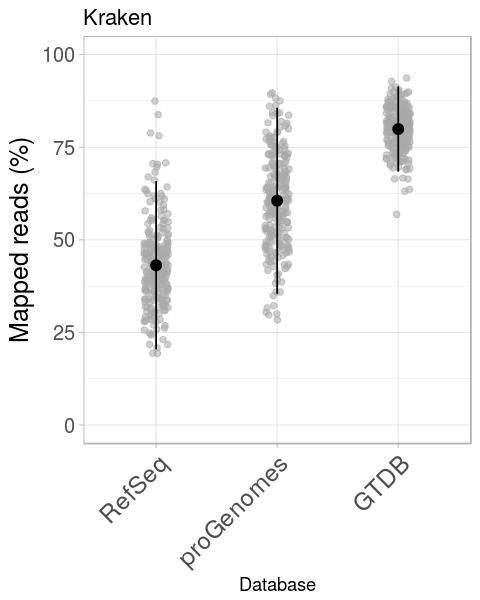

In [18]:
options(repr.plot.width = 4, repr.plot.height = 5)

k_plt = kraken_classified %>%
    ggplot(aes(x = database, y = (proportion))) +
        geom_jitter(position=position_jitter(0.1), aes(alpha = 0.01), color = "#A9A9A9") +
        stat_summary(fun.data=mean_sdl, geom="pointrange", color="black") +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
              axis.text.y = element_text(size = 12), 
              axis.title.y = element_text(size = 15),
              legend.position = "none") +
        labs(x = "Database", y = "Mapped reads (%)", title = "Kraken") +
        lims(y = c(0,100))


plot(k_plt)

### Bracken - proportion of used read at species level

In [19]:
# Determine the number of reads actually used by Bracken
br_total = bracken_used_complete %>% 
    filter(category == "Total") %>%
    pull(seqs)

br_used = bracken_used_complete %>% 
    filter(category == "Used") %>%
    pull(seqs)

br_proportion = bracken_used_complete %>% 
    filter(category == "Used") %>%
    select(community, database) %>%
    mutate(proportion = (br_used /br_total)*100)

br_proportion %>% head

community,database,proportion
1002314,GTDB,60.92871
1002314,proGenomes,51.71795
1002314,RefSeq,38.93073
1002317,GTDB,58.89292
1002317,proGenomes,52.17648
1002317,RefSeq,30.66088


In [20]:
# Summary of used reads per database
br_proportion %>%
    group_by(database) %>% 
    summarise(mean = mean(proportion), sd = sd(proportion))

database,mean,sd
RefSeq,36.56493,9.341537
proGenomes,51.74847,10.767468
GTDB,66.42228,4.976814


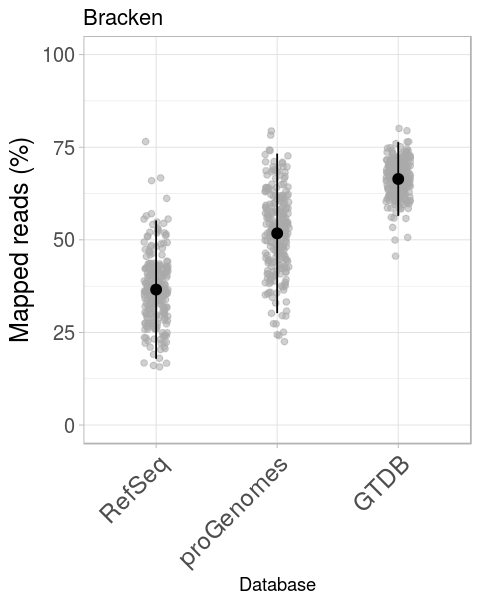

In [21]:
options(repr.plot.width = 4, repr.plot.height = 5)
b_plt = br_proportion %>%
    ggplot(aes(x = database, y = proportion)) +
        geom_jitter(position=position_jitter(0.1), aes(alpha = 0.01), color = "#A9A9A9") +
        stat_summary(fun.data=mean_sdl, geom="pointrange", color="black") +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
              axis.text.y = element_text(size = 12), 
              axis.title.y = element_text(size = 15),
              legend.position = "none") +
        labs(x = "Database", y = "Mapped reads (%)", title = "Bracken") +
        lims(y = c(0,100))


plot(b_plt)

### Kraken-Bracken Plots

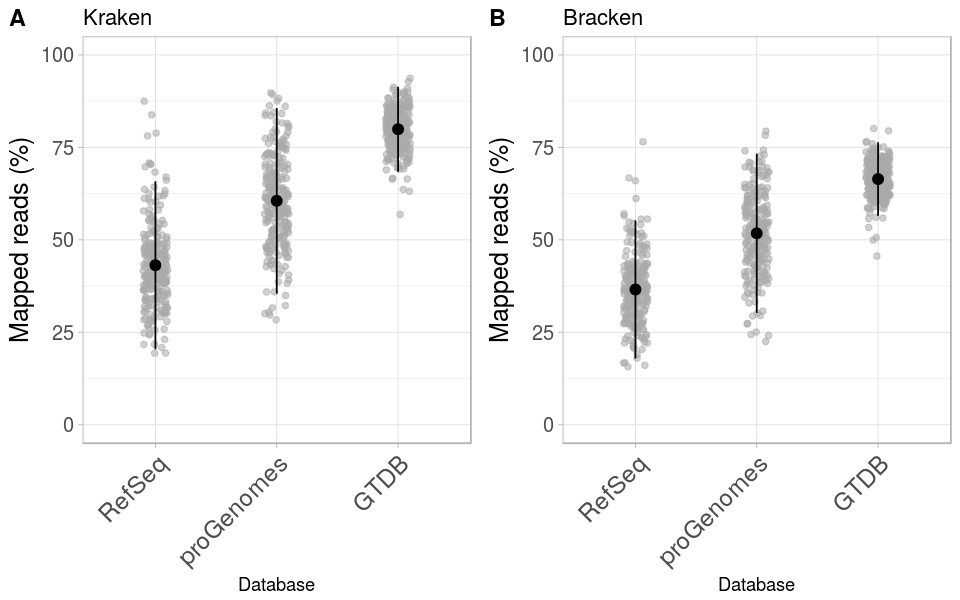

In [22]:
# Kraken and Bracken mapping
options(repr.plot.width = 8, repr.plot.height = 5)
plot_grid(k_plt, b_plt, nrow = 1, labels = "AUTO")

## Functional Profile

### HUMANn2 proportion of mapped reads after nucleotide search

In [23]:
# Translated 
hmn2_proportion = human_mapped %>%
    filter(category == "Nucleotide") %>%
    select(-category)

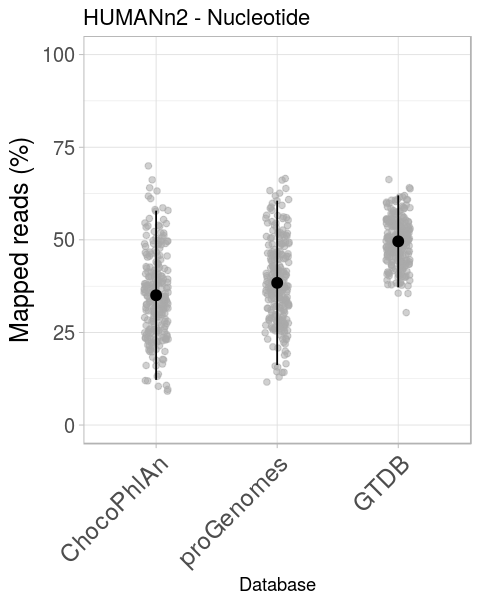

In [24]:
options(repr.plot.width = 4, repr.plot.height = 5)
hmn2_nuc_plt = hmn2_proportion %>%
    ggplot(aes(x = database, y = proportion)) +
        geom_jitter(position=position_jitter(0.1), aes(alpha = 0.01), color = "#A9A9A9") +
        stat_summary(fun.data=mean_sdl, geom="pointrange", color="black") +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
              axis.text.y = element_text(size = 12), 
              axis.title.y = element_text(size = 15),
              legend.position = "none") +
        labs(x = "Database", y = "Mapped reads (%)", title = "HUMANn2 - Nucleotide") +
        lims(y = c(0,100))


plot(hmn2_nuc_plt)

### HUMANn2 proportion of mapped reads after translated search

In [25]:
# Filter table
hmn2_proportion = human_mapped %>%
    filter(category == "Translated") %>%
    select(-category)

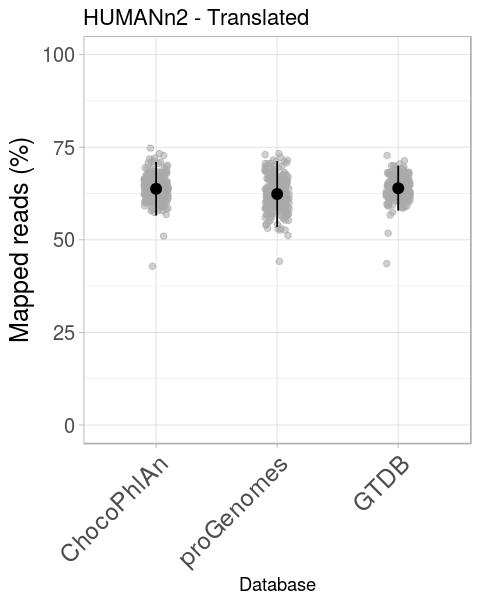

In [26]:
options(repr.plot.width = 4, repr.plot.height = 5)
hmn2_trns_plt = hmn2_proportion %>%
    ggplot(aes(x = database, y = proportion)) +
        geom_jitter(position=position_jitter(0.1), aes(alpha = 0.01), color = "#A9A9A9") +
        stat_summary(fun.data=mean_sdl, geom="pointrange", color="black") +
        theme_light() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 15),
              axis.text.y = element_text(size = 12), 
              axis.title.y = element_text(size = 15),
              legend.position = "none") +
        labs(x = "Database", y = "Mapped reads (%)", title = "HUMANn2 - Translated") +
        lims(y = c(0,100))


plot(hmn2_trns_plt)

# All plots combined

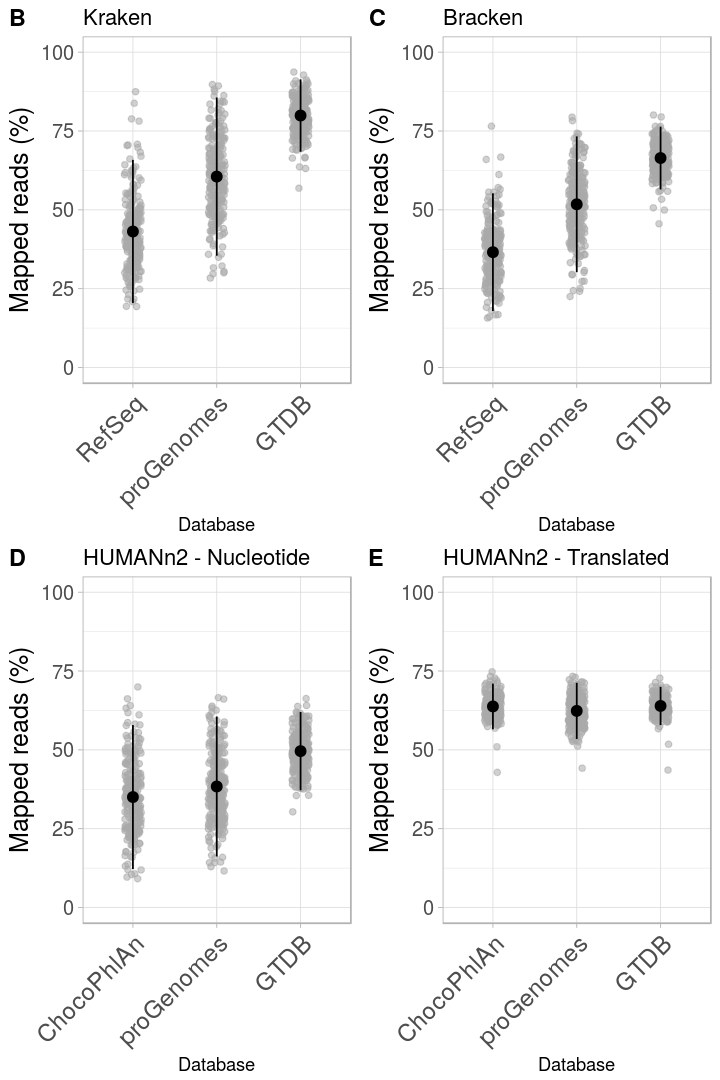

In [27]:
# Kraken and Bracken mapping
options(repr.plot.width = 6, repr.plot.height = 9)
final_plot = plot_grid(k_plt, b_plt, hmn2_nuc_plt, hmn2_trns_plt, 
                       nrow = 2, labels = c("B", "C", "D", "E"))
final_plot

In [77]:
# Save plot
plot_file = "./images/BGI250_plot_combined.png"
save_plot(filename = plot_file, plot = final_plot,
          base_height = 9, base_width = 6, dpi = 300)

# Session Info

In [28]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/UpSetR/lib/R/lib/libRblas.so
LAPACK: /ebio/abt3_projects/software/miniconda3_gt4.4/envs/UpSetR/lib/R/lib/libRlapack.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2        glue_1.2.0          data.table_1.10.4-3
 [4] cowplot_0.9.3       forcats_0.2.0       stringr_1.2.0      
 [7] dplyr_0.7.4         purrr_0.2.4         readr_1.1.1        
[10] tidyr_0.7.2         tibble_1.4.1        ggplot2_2.2.1      
[13] tidyverse_1.1.1    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.14        lubridate_1.7.4     lattice_0.20-35    
 [4] assertthat_0.2.0    digest_0.6.13       IRdisplay_0.4.4    
 [7] R6_2.2.2            cellranger_1.1.0    plyr_1.8.4         
[10] repr_0.15.0      